In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from tqdm import tqdm

from glob import glob

import librosa
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from torch.optim import Adam

from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import time

from pykalman import KalmanFilter

In [2]:
# performing a check
id = 35
path = f'DEAM_Dataset/DEAM_audio/MEMD_audio/{id}.mp3'
y, sr = librosa.load(path, sr=44100)
print(f"{len(y)} samples at {sr} Hz")


1986607 samples at 44100 Hz


In [3]:
def compute_beats(y, sr, hop_length):

    tempo, beat_frames = librosa.beat.beat_track(
        y=y,
        sr=sr,
        hop_length=hop_length,
        units="frames"
    )

    beat_times_sec = librosa.frames_to_time(
        beat_frames,
        sr=sr,
        hop_length=hop_length
    )

    return beat_times_sec, beat_frames, tempo

In [4]:
def aggregate_feature(mfcc, cens, beat_frames, beat_times):

    X = []
    durations = []

    # beat_durations = np.diff(beat_times)
    # beat_durations = np.clip(beat_durations, 1e-2, None)

    # tempo_inst = 60.0 / beat_durations
    # tempo_features = np.column_stack([
    #         tempo_inst,
    #         np.log(tempo_inst),
    #         np.diff(np.concatenate([[tempo_inst[0]], tempo_inst]))
    #     ])

    for t in range(len(beat_frames) - 1):
        start = beat_frames[t]
        end   = beat_frames[t + 1]

        if end > start:
            mfcc_t = mfcc[start:end].mean(axis=0)
            cens_t = cens[start:end].mean(axis=0)
        else:
            mfcc_t = mfcc[start]
            cens_t = cens[start:end]

        X.append(np.concatenate([mfcc_t, cens_t]))
        durations.append(beat_times[t + 1] - beat_times[t])



    X = np.vstack(X)
    return X, np.array(durations)

In [5]:
def parse_annotation_times(df):

    time_cols = [c for c in df.columns if c.startswith("sample_")]

    times_sec = np.array([int(c.replace("sample_", "").replace("ms", "")) / 1000.0
                          for c in time_cols])

    return time_cols, times_sec

In [6]:
def aggregate_annotations_to_beats(
        times_sec,
        values,
        beat_times_sec
):

    y_beats = []

    for t in range(len(beat_times_sec) - 1):
        start = beat_times_sec[t]
        end   = beat_times_sec[t + 1]

        mask = (times_sec >= start) & (times_sec < end)

        if np.any(mask):
            y_beats.append(values[mask].mean())
        else:
            idx = np.argmin(np.abs(times_sec - start))
            y_beats.append(values[idx])
    return np.array(y_beats)

In [7]:
def get_song_ids(filepath):

    ids = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if ".mp3" in file:
                ids.append(file[:file.index(".")])

    return ids

In [8]:
class DEAMDataset(Dataset):

    def __init__(
            self,
            audio_dir,
            arousal_labels,
            valence_labels,
            song_ids,
            hop_length=512,
            n_mfcc=20
    ):

        self.audio_dir = audio_dir
        self.arousal_labels = pd.read_csv(arousal_labels)
        self.valence_labels = pd.read_csv(valence_labels)
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.song_ids = song_ids
        self.cache = {}
        self.time_cols, self.time_sec = parse_annotation_times(self.valence_labels)

        self.valence_labels["song_id"] = self.valence_labels["song_id"].astype(str).str.strip()
        self.arousal_labels["song_id"] = self.arousal_labels["song_id"].astype(str).str.strip()

        self.valence_dict = self.valence_labels.set_index("song_id")
        self.arousal_dict = self.arousal_labels.set_index("song_id")


    def __len__(self):
        return len(self.song_ids)

    def __getitem__(self, idx):

        song_id = self.song_ids[idx]

        if song_id in self.cache:
          return self.cache[song_id]

        path = os.path.join(self.audio_dir, f"{song_id}.mp3")

        # y, sr = librosa.load(path, sr=44100)

        # beat_times_sec, beat_frames, tempo = compute_beats(y, sr, self.hop_length)

        y, sr = librosa.load(path, sr=22050, mono=True)

        tempo, beat_frames = librosa.beat.beat_track(
          y=y, sr=sr, hop_length=self.hop_length, units="frames"
        )

        beat_times_sec = librosa.frames_to_time(beat_frames, sr=sr, hop_length=self.hop_length)

        if beat_times_sec is None or len(beat_times_sec) < 2:
          return None

        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=self.n_mfcc,
            hop_length=self.hop_length
        ).T

        cens = librosa.feature.chroma_cens(
            y=y,
            sr=sr,
            hop_length=self.hop_length
        ).T

        X, durations = aggregate_feature(mfcc, cens, beat_frames, beat_times_sec)

        valence = self.valence_dict.loc[str(song_id), self.time_cols].values
        arousal = self.arousal_dict.loc[str(song_id), self.time_cols].values

        val_beats = aggregate_annotations_to_beats(self.time_sec, valence, beat_times_sec)
        aro_beats = aggregate_annotations_to_beats(self.time_sec, arousal, beat_times_sec)

        X = torch.tensor(X, dtype=torch.float32)

        y = np.column_stack([val_beats, aro_beats])

        valid = ~np.isnan(y).any(axis=1)

        X = X[valid]
        y = y[valid]
        durations = durations[valid]

        y = torch.tensor(y, dtype=torch.float32)

        durations = torch.tensor(durations, dtype=torch.float32)

        if X.shape[0] == 0 or y.shape[0] == 0:
          return None

        if not torch.isfinite(X).all():
          return None
        if not torch.isfinite(y).all():
          return None

        sample = {
            "X": X,
            "y": y,
            "durations": durations,
            "song_id": song_id
        }

        self.cache[song_id] = sample
        return sample


In [9]:
ids = get_song_ids("DEAM_Dataset/DEAM_audio/MEMD_audio")

dataset = DEAMDataset("DEAM_Dataset/DEAM_audio/MEMD_audio",
                           "DEAM_Dataset/DEAM_Annotations/annotations/annotations averaged per song/dynamic (per second annotations)/arousal.csv",
                           "DEAM_Dataset/DEAM_Annotations/annotations/annotations averaged per song/dynamic (per second annotations)/valence.csv",
                           ids)

print("Precomputing features...")
for i in tqdm(range(len(dataset))):
    _ = dataset[i]
print("Done.")

Precomputing features...


100%|██████████| 1802/1802 [18:12<00:00,  1.65it/s]

Done.


In [10]:
class BeatRegressor(nn.Module):

    def __init__(self, input_dim):

        super().__init__()
        self.next = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.next(x)

In [22]:
def flatten_collate(batch):

    batch = [b for b in batch if b is not None]

    if len(batch) == 0:
        return None, None

    X_list = [b["X"] for b in batch]
    y_list = [b["y"] for b in batch]

    X = torch.cat(X_list, dim=0)
    y = torch.cat(y_list, dim=0)

    durations = torch.cat([b["durations"] for b in batch], dim=0)

    song_ids = []
    for b in batch:
        song_ids.extend([b["song_id"]] * len(b["X"]))

    return X, y, durations, song_ids



In [12]:
num_songs = len(dataset)
indices = np.arange(num_songs)
kf = KFold(n_splits=10, shuffle=True, random_state=42)


In [17]:
def compute_normalization(loader):
    X_all = []

    for X, _, _, _ in loader:
        if X is None:
            continue
        X_all.append(X)

    if len(X_all) == 0:
        raise RuntimeError("No valid samples found")

    X_all = torch.cat(X_all, dim=0)
    mean = X_all.mean(dim=0)
    std = X_all.std(dim=0) + 1e-6
    return mean, std

===== Fold 1 of 10 =====
Collected 1616 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1616,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding with initial Kalman parameters to avoid long/stalled EM runs.
===== Fold 2 of 10 =====
Collected 1618 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1618,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding with initial Kalman parameters to avoid long/stalled EM runs.
===== Fold 3 of 10 =====
Collected 1617 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1617,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding wit

===== Fold 1 of 10 =====
Collected 1616 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1616,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding with initial Kalman parameters to avoid long/stalled EM runs.
===== Fold 2 of 10 =====
Collected 1618 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1618,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding with initial Kalman parameters to avoid long/stalled EM runs.
===== Fold 3 of 10 =====
Collected 1617 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1617,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding wit

KeyboardInterrupt: 

===== Fold 1 of 10 =====
Collected 1616 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1616,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding with initial Kalman parameters to avoid long/stalled EM runs.
===== Fold 2 of 10 =====
Collected 1618 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1618,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding with initial Kalman parameters to avoid long/stalled EM runs.
===== Fold 3 of 10 =====
Collected 1617 valid sequences, 0 problematic songs
Attempting EM with object-dtype sequence array, shape: (1617,)
Kalman EM failed on object-dtype sequences: ValueError('could not broadcast input array from shape (2,2) into shape (2,1)')
Skipping EM and proceeding wit

KeyboardInterrupt: 

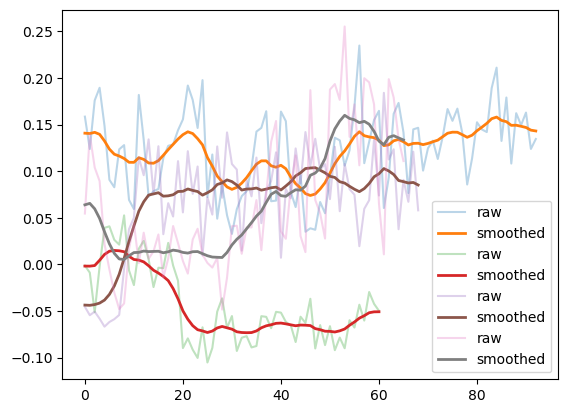

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

fold_results = []
r_val = []
r_aro = []

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"===== Fold {fold + 1} of 10 =====")

    train_set = Subset(dataset, train_idx)

    val_set = Subset(dataset, val_idx)

    train_loader = DataLoader(
        train_set,
        batch_size=8,
        shuffle=True,
        collate_fn=flatten_collate
    )

    val_loader = DataLoader(
        dataset=val_set,
        batch_size=8,
        shuffle=False,
        collate_fn=flatten_collate
    )

    mean, std = compute_normalization(train_loader)

    input_dim = train_set[0]["X"].shape[1]

    model = BeatRegressor(input_dim).to(device)

    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")

    pred_sequences = []

    song_preds_temp = {}
    with torch.no_grad():
        for X, y, durations, song_ids in train_loader:
            if X is None:
                continue

            X = ((X - mean) / std).to(device)
            y_hat = model(X).cpu().numpy()
            durations = durations.cpu().numpy()

            for i, song_id in enumerate(song_ids):
                if song_id not in song_preds_temp:
                    song_preds_temp[song_id] = {
                        "preds": [],
                        "durs": []
                    }

                song_preds_temp[song_id]["preds"].append(y_hat[i])
                song_preds_temp[song_id]["durs"].append(durations[i])

    for song_id in song_preds_temp:
        preds = np.vstack(song_preds_temp[song_id]["preds"])
        pred_sequences.append(preds)

    if len(pred_sequences) == 0:
        raise RuntimeError("No prediction sequences gathered for Kalman EM")

    kalman = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=np.eye(2),
        transition_covariance=0.01 * np.eye(2),
        observation_covariance=0.1 * np.eye(2),
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2)
    )

    kalman = kalman.em(pred_sequences, n_iter=20)

    for epoch in range(30):
        model.train()
        train_loss = 0.0

        train_corr_valence = 0.0
        train_corr_arousal = 0.0

        n_batches = 0

        for X, y, _, _ in train_loader:

            X = ((X - mean) / std).to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            n_batches += 1

        train_loss /= n_batches

        song_preds = {}
        song_targets = {}

        model.eval()

        val_loss = 0.0
        n_batches = 0

        with torch.no_grad():
            for X, y, durations, song_ids in val_loader:
                
                X = ((X - mean) / std).to(device)
                y = y.to(device)

                y_hat_tensor = model(X)
                val_loss += criterion(y_hat_tensor, y).item()
                y_hat = y_hat_tensor.cpu().numpy()

                durations = durations.cpu().numpy()

                for i, song_id in enumerate(song_ids):
                    if song_id not in song_preds:
                        song_preds[song_id] = {
                            "preds": [],
                            "durs": []
                        }

                        song_targets[song_id] = y[i].cpu().numpy()

                    song_preds[song_id]["preds"].append(y_hat[i])
                    song_preds[song_id]["durs"].append(durations[i])

                n_batches += 1

        val_loss /= n_batches

        y_song_pred = []
        y_song_true = []
        
        for song_id in song_preds:
            preds = np.vstack(song_preds[song_id]["preds"])

            durs = np.hstack(song_preds[song_id]["durs"])

            # -- smoothing --

            smoothed, _ = kalman.smooth(preds)
            song_pred_smooth = np.average(smoothed, axis=0, weights=durs)

            song_pred_unsmooth = np.average(
                preds,
                axis=0,
                weights=durs
            )


            y_song_pred.append(song_pred_smooth)
            y_song_true.append(song_targets[song_id])
        
        y_song_pred = np.array(y_song_pred)
        y_song_true = np.array(y_song_true)

        r_valence, _ = pearsonr(y_song_true[:, 0], y_song_pred[:, 0])
        r_arousal, _ = pearsonr(y_song_true[:, 1], y_song_pred[:, 1])

        r_val.append(r_valence)
        r_aro.append(r_arousal)

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train MSE: {train_loss:.4f} | "
            f"Val MSE: {val_loss:.4f} "
        )

        best_val_loss = min(best_val_loss, val_loss)

    fold_results.append(best_val_loss)


In [28]:
fold_results = np.array(fold_results)

print("10-Fold CV Results:")
print(f"Mean MSE: {fold_results.mean():.4f}")
print(f"Std  MSE: {fold_results.std():.4f}")

print(f"Valence r: {np.mean(r_val):.3f} ± {np.std(r_val):.3f}")
print(f"Arousal r: {np.mean(r_aro):.3f} ± {np.std(r_aro):.3f}")


10-Fold CV Results:
Mean MSE: 0.0422
Std  MSE: 0.0025
Valence r: 0.519 ± 0.052
Arousal r: 0.741 ± 0.021


In [29]:
save_path = "deam_beat_regressor.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "input_dim": input_dim,
    "mean": mean.cpu(),
    "std": std.cpu(),
}, save_path)

In [30]:
checkpoint = torch.load("deam_beat_regressor.pt", map_location=device)

model = BeatRegressor(checkpoint["input_dim"]).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

mean = checkpoint["mean"].to(device)
std = checkpoint["std"].to(device)